## SMSecure 

SMSecure è un progetto che ha come obiettivo quello di realizzare un filtro anti spam. Quindi a partire da un semplice dataset andrò ad effettuare le operazioni necessarie per trovare relazioni tra i dati, preprocessare i dati, e infine utilizzare i dati per addestrare un modello di ML.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

leggo il dataset e stampo un campione (prime 5 righe)

In [43]:
df = pd.read_csv('sms_dataset.csv', encoding="ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
569,ham,WOT U WANNA DO THEN MISSY?,NaN,NaN,NaN
896,ham,Hope you are having a good week. Just checking in,NaN,NaN,NaN
4779,ham,Sen told that he is going to join his uncle fi...,NaN,NaN,NaN
2419,spam,SMS SERVICES For your inclusive text credits p...,NaN,NaN,NaN
2806,spam,December only! Had your mobile 11mths+? You ar...,NaN,NaN,NaN


numero righe e colonne del dataset

In [44]:
df.shape

(5572, 5)

## Data Cleaning

stampo le info del dataset per fare una panoramica

In [45]:
df.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN

si può notare che ci sono delle colonne inutili (ultime 3), quindi vanno eliminate

In [46]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.sample(5)

,v1,v2
3787,spam,Want to funk up ur fone with a weekly new tone...
1567,ham,"whatever, im pretty pissed off."
2884,ham,ÌÏ still attending da talks?
1093,ham,Well the weather in cali's great. But its comp...
5027,ham,Go chase after her and run her over while she'...


rinomino le colonne v1 e v2 con nomi migliori

In [47]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
272,spam,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...
958,ham,My sort code is and acc no is . The bank is n...
4195,ham,"Sorry, it's a lot of friend-of-a-friend stuff,..."
5195,ham,Darren was saying dat if u meeting da ge den w...
5136,ham,There are some nice pubs near here or there is...


ora devo traformare il target "ham/spam" in codifica binaria 0/1 quindi ho bisogno di sickitLearn e più nello specifico di LabelEncoder che viene utilizzato per convertire etichette categoriche in numeri interi in modo che possano essere utilizzate come input per algoritmi di machine learning. 


In [48]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [49]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
2439,0,Rightio. 11.48 it is then. Well arent we all u...
1309,0,"Ok, be careful ! Don't text and drive !"
1473,0,"Will do, you gonna be at blake's all night? I ..."
1149,0,Not a drop in the tank
2104,0,Anyway seriously hit me up when you're back be...


quindi ora gli spam saranno indicati come 1, gli ham come 0

controllo se sono presenti valori nulli o duplicati, e nel caso risolvo

In [50]:
df.isnull().sum()

target    0
text      0
dtype: int64

non ci sono valori nulli, procedo a verificare eventuali duplicati

In [51]:
df.duplicated().sum()

403

procedo a rimuovere i 403 duplicati

In [52]:
df = df.drop_duplicates(keep='first')

In [53]:
df.duplicated().sum()

0

ho risolto! Ora il dataset ha 0 nulli e 0 duplicati

# Analisi dei dati

fase in cui si esplorano, visualizzano e comprendono i dati per scoprire informazioni rilevanti, tendenze, relazioni e anomalie nei dati.

In [54]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Quindi il mio dataset ha 4516 SMS "ham" e 653 "spam"

vado a rappresentare tale informazione usando un grafico a torta

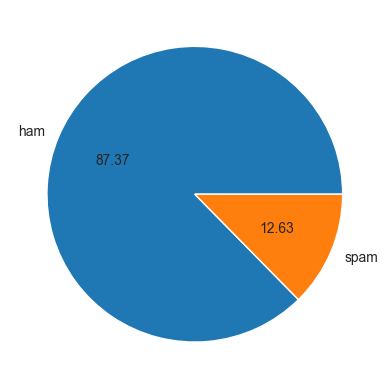

In [55]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

Quindi da tale grafico si può notare che i dati non sono bilanciati

# Data Preparation (Data Balancing )

provo a bilanciare i dati, andando a fare un clustering. Dopo aver eseguito il clustering, ed avere individuato i migliori clustering, ovvero quelli più rappresentativi grazie silhouette, vado a selezionare un pò di dati da questi cluster.
L'indice silhouette è una misura usata per valutare la qualità della clusterizzazione dei dati in un problema di clustering. È spesso utilizzato per valutare quanto bene i dati sono stati assegnati ai cluster. 

Il punteggio silhouette varia da -1 a 1, dove:

- Valori vicini a 1 indicano che il campione è stato assegnato correttamente al cluster.
- Valori vicini a 0 indicano che il campione è vicino ai confini tra due cluster.
- Valori vicini a -1 indicano che il campione è stato assegnato erroneamente al cluster sbagliato.
- In generale, un valore silhouette più alto è indicativo di una migliore clusterizzazione. 

In [56]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score

# Divido il dataframe in due parti separate ham/spam
ham = df[df['target'] == 0]
spam = df[df['target'] == 1]

# Eseguo il clustering dei campioni "ham" con K-Means (ML non supervisionato)
num_clusters = 2 # ho scelto un numero di cluster in base ai valori medi della silhouette
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))

# Calcolo il valore della Silhouette per ciascun campione
sample_silhouette_values = silhouette_samples(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Calcola la Silhouette Score media per tutti i campioni nella classe "ham"
silhouette_avg = silhouette_score(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Trovo i cluster con Silhouette Score più alti
best_clusters = []
for cluster_id in range(num_clusters):
    cluster_silhouette_values = sample_silhouette_values[ham['cluster'] == cluster_id]
    avg_silhouette = np.mean(cluster_silhouette_values)
    best_clusters.append((cluster_id, avg_silhouette))

for cluster_id, avg_silhouette in best_clusters:   #stampa usata per vedere i valori della silhouette
    print(f"Cluster {cluster_id}: Silhouette Score medio = {avg_silhouette}")

# Ordino i cluster in base alla Silhouette Score in ordine decrescente
best_clusters = sorted(best_clusters, key=lambda x: x[1], reverse=True)

# Scelgo i primi 2 cluster (i migliori) come cluster rappresentativi
representative_clusters = [cluster[0] for cluster in best_clusters[:2]] 

# Eseguo l'undersampling dai cluster rappresentativi, ovvero prendo solo un tot di righe da essi.

undersampled_ham = pd.DataFrame() #creo un nuovo dataframe

num_samples_per_cluster = 320  # Numero di campioni da campionare da ciascun cluster rappresentativo

#vado a selezionare 320 campioni dai due cluster migliori, e li inserisco nel dataframe undersampled_ham.
for cluster_id in representative_clusters:
    cluster_samples = ham[ham['cluster'] == cluster_id]
    # Eseguo l'undersampling (campiona da ciascun cluster rappresentativo)
    cluster_samples = resample(cluster_samples, replace=False, n_samples=num_samples_per_cluster, random_state=42)
    # Aggiungo i campioni campionati all'insieme di campioni sottocampionati
    undersampled_ham = pd.concat([undersampled_ham, cluster_samples])

# Combina l'undersampled classe "ham" con il dataframe che contiene la classe "spam" per ottenere il dataset bilanciato
df_undersampled = pd.concat([undersampled_ham, spam])

# Ora df_undersampled contiene il dataset bilanciato, quindi copio in variabile df, ovvero il df che uso di default.

df = df_undersampled


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_10493/1625856083.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))


Cluster 0: Silhouette Score medio = 0.5025812842854496
Cluster 1: Silhouette Score medio = 0.7404661949423422


Basandomi sui punteggi della Silhouette Score media:

- 2 cluster: Cluster 0 con Silhouette Score medio 0.716 e Cluster 1 con Silhouette Score medio 0.564.
- 3 cluster: Cluster 0 con Silhouette Score medio 0.716, Cluster 1 con Silhouette Score medio 0.564, e Cluster 2 con Silhouette Score medio 0.414.
- 5 cluster: il Cluster 0 con 0.50, Cluster 1 con 0.49, Cluster 2 con 0.55, Cluster 3 con 0.50, Cluster 4 con 0.65

Tra le opzioni di 2 cluster, 3 cluster e 5 cluster, mi è sembrato opportuno fare una suddivisione in 2 cluster, difatti il silouhette score medio è più alto.

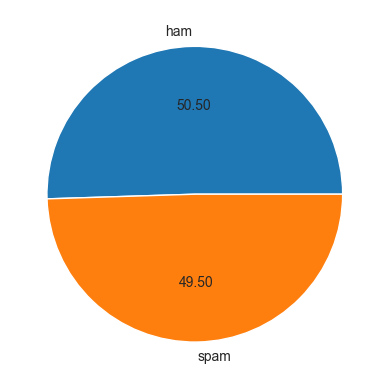

In [57]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

In [58]:
df['target'].value_counts()

target
1    653
0    640
Name: count, dtype: int64

ora posso andare copiare tutto su df, eliminando la colonna cluster dato che non mi servirà più

In [59]:
df = df_undersampled.drop(columns=['cluster'])
df.sample(5)

,target,text
4054,0,When is school starting. Where will you stay. ...
65,1,"As a valued customer, I am pleased to advise y..."
3131,0,I've been barred from all B and Q stores for l...
1228,1,FREE entry into our å£250 weekly comp just sen...
1793,0,You bad girl. I can still remember them


In [60]:
#ho dovuto fare tutto ciò perchè non riuscivo a effettuare il download di nltk
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ho scaricato la libreria Nltk Python ampiamente utilizzata per il trattamento del linguaggio naturale. Tra gli strumenti presenti, c'è il tokenizer NLTK denominato "Punkt" che viene utilizzato per la suddivisione di testo in frasi ed è molto utile quando si desidera suddividere un testo in frasi al fine di analizzarle o elaborarle in modo più dettagliato.

ora vado a vedere la lungehzza in caratteri di ogni messaggio 

In [61]:
df['text'].apply(len) 


1147     45
437      36
2283     33
5514     33
3443     44
       ... 
5537     90
5540    160
5547    160
5566    147
5567    161
Name: text, Length: 1293, dtype: int64

quindi creo una nuova colonna nel dataset in cui indico il numero di caratteri e stampo un sample per vedere che tutto ha funzionato

In [62]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
1147,0,Ok... Help me ask if she's working tmr a not?,45
437,0,How long does applebees fucking take,36
2283,0,I reach home safe n sound liao...,33
5514,0,Oh... Okie lor...We go on sat...,33
3443,0,Yes but I don't care cause I know its there!,44


vado ora a calcolare il numero di parole in ogni messaggio, utilizzando il tokenizer della libreria nltk. Vado anche qui a creare una colonna.

In [63]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
1147,0,Ok... Help me ask if she's working tmr a not?,45,13
437,0,How long does applebees fucking take,36,6
2283,0,I reach home safe n sound liao...,33,8
5514,0,Oh... Okie lor...We go on sat...,33,10
3443,0,Yes but I don't care cause I know its there!,44,12


vado ora a calcolare il numero di frasi per ogni messaggio e metto i dati in una nuova colonna

In [64]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
1147,0,Ok... Help me ask if she's working tmr a not?,45,13,1
437,0,How long does applebees fucking take,36,6,1
2283,0,I reach home safe n sound liao...,33,8,1
5514,0,Oh... Okie lor...We go on sat...,33,10,1
3443,0,Yes but I don't care cause I know its there!,44,12,1


stampo un grafico che mi faccia vedere le differenze di caratteri tra sms ham/spam.

<Axes: xlabel='num_characters', ylabel='Count'>

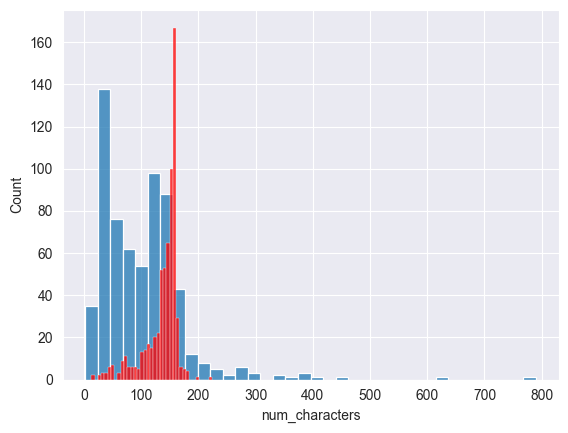

In [65]:
import seaborn as sns
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'], color='red')


Quindi si può notare che i messaggi spam in media hanno un numero di caratteri abbastanza alto.

Ora vado a stampare lo stesso tipo di grafico, ma per il numero di parole.

<Axes: xlabel='num_words', ylabel='Count'>

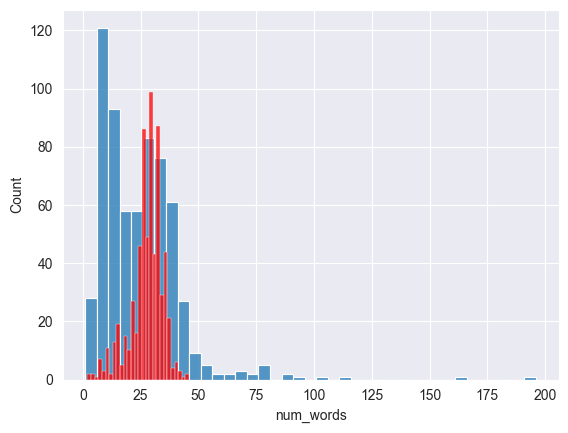

In [66]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'], color='red')

Inoltre come si può notare da tale grafico, i messaggi spam hanno in media un numero di parole abbastanza alto. Difatti si verifica, come si può notare dalle colonne rosse, che addirittura in 100 esemplari spam il testo sia di oltre 30 words. Mentre nei messagi legittimi (ham) il numero di words è in determinati casi più basso.

Ora stampo un grafico riassuntivo, un pairplot.
In un pairplot, ciascuna variabile numerica presente nel dataset viene confrontata con tutte le altre variabili numeriche tramite grafici a dispersione, quindi vengono mostrati i punti di dati lungo l'incrocio di tutte le variabili, consentendo di visualizzare e individuare eventuali relazioni o tendenze tra le variabili.

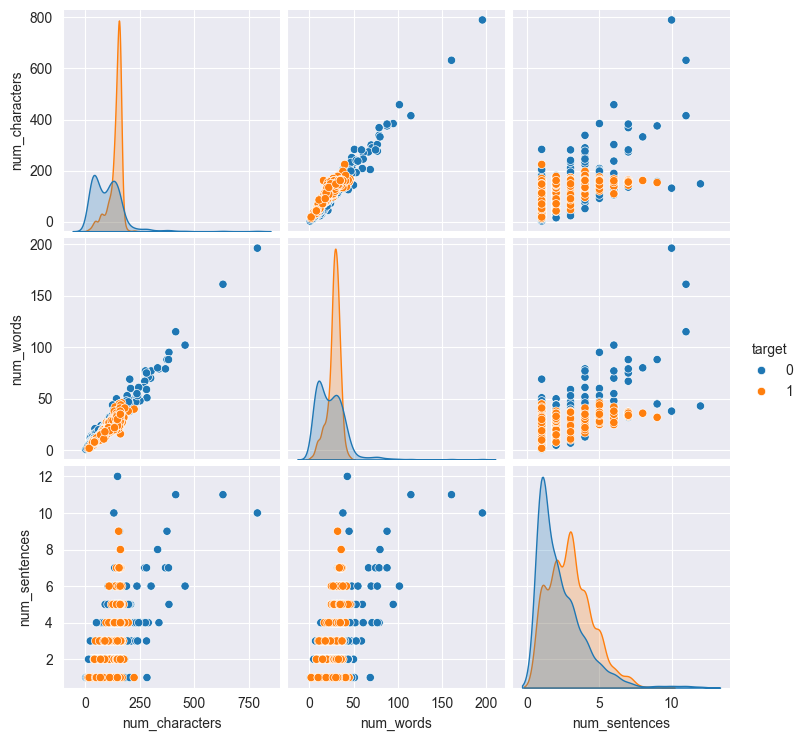

In [67]:
sns.pairplot(df, hue='target')

Emerge dal pairplot:
- sms spam hanno in media un numero di caratteri maggiore dei messaggi ham
- sms spam hanno in media un numero di word maggiore rispetto ai messaggi ham
- il numero di frasi è invece prevalentemente maggiore negli sms ham.

Vado a visualizzare gli stessi dati con la matrice di correlazione, che mi restituisce le correlazioni tra le variabili del dataset, prima di fare ciò devo escludere dal dataframe la colonna text

In [68]:
df_without_text = df.drop(columns=["text"])
df_without_text.corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.316661,0.125776,0.214139
num_characters,0.316661,1.000000,0.947130,0.563920
num_words,0.125776,0.947130,1.000000,0.601278
num_sentences,0.214139,0.563920,0.601278,1.000000


vado a rappresentare tali valori con una heatmap che utilizza colori per visualizzare i valori dei coefficienti di correlazione tra le diverse coppie di variabili nel dataset, consentendo di individuare facilmente relazioni tra di esse.
All'interno della mappa:
- Le celle più scure o più chiare indicano correlazioni più forti o più deboli, rispettivamente. 
- le variabili che sono fortemente correlate tra loro (valori vicini a 1 o -1) o variabili che hanno una bassa correlazione (valori vicini a 0).

<Axes: >

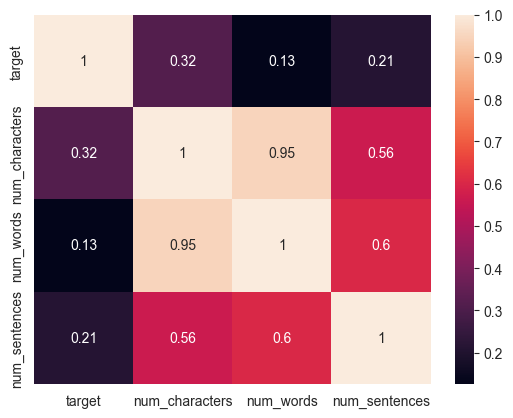

In [69]:
sns.heatmap(df_without_text.corr(), annot=True)

Dalla heatmap emergono svariate considerazioni facilemente spiegabili: 
- forte correlazioni tra numero di parole e numero di caratteri


# Data preparation (Data cleaning)

Rientra nella fase di pulizia dei dati, e vado ad eseguire i seguenti passaggi:
- portare tutto il testo in miniscolo
- tokenizzazione
- rimozione caratteri speciali
- rimozione punteggiatura e stopwords
- stemming (sostituire le parole con la loro radice)

Creo una funzione che esegua tutti questi passi, che prenda in input del testo, e mi restituisca in output del testo preprocessato, ovvero minuscolo, tokenizzato, senza caratteri speciali e stopword, con tutte le words riporatte alla forma base.

In [70]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#stemmer utilizzato per ridurre le parole alla loro forma di base (stemma/radice).
ps = PorterStemmer() 



def transform_text(text):
    text = text.lower() #trasforma tutto in minuscolo per una maggiore coerenza durante l'analisi
    text = nltk.word_tokenize(text) #Utilizza la tokenizzazione per suddividere il testo in una lista di parole (token).
    
    #Rimuove i caratteri non alfanumerici (simboli che non sono né lettere dell'alfabeto né numeri) mantenendo solo le parole alfanumeriche.
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    # Rimuove le stopwords (parole comuni senza un significato specifico) e la punteggiatura.
    #Le stopwords sono parole comuni considerate insignificanti ai fini dell'analisi del testo perché sono molto frequenti in una lingua, ma portano con sé poco significato (come gli articoli, le preposizioni, le congiunzioni ecc. ).
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    #Esegue lo stemming delle parole (riduzione alla forma base/radice utile per ridurre le variazioni delle parole semplificando così l'analisi del testo
    for i in text:
        y.append(ps.stem(i))
    
    #Restituisce il testo pre-elaborato come una stringa di parole separate tra spazi.        
    return " ".join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


test funzione su più frasi:

In [71]:
transform_text('"Data scientists use tools like Python, R, and SQL to analyze large datasets, employing machine learning algorithms to extract valuable insights and patterns!"')

'data scientist use tool like python r sql analyz larg dataset employ machin learn algorithm extract valuabl insight pattern'

In [72]:
transform_text('URGENT!! 🚨 Your 100 % FREE PRIZE awaits! Claim NOW by texting "WIN" to 555-1234. Don t miss this EXCLUSIVE offer! 🎁🌟')

'urgent 100 free prize await claim text win miss exclus offer'

Ora procedo a trasformare il testo di tutti gli sms presenti nel dataset, e li inserisco in una nuova colonna.


In [73]:
df['text'].apply(transform_text)

1147                                 ok help ask work tmr
437                                long applebe fuck take
2283                         reach home safe n sound liao
5514                                    oh oki lor go sat
3443                                    ye care caus know
                              ...                        
5537    want explicit sex 30 sec ring 02073162414 cost...
5540    ask 3mobil 0870 chatlin inclu free min india c...
5547    contract mobil 11 mnth latest motorola nokia e...
5566    remind o2 get pound free call credit detail gr...
5567    2nd time tri 2 contact u pound prize 2 claim e...
Name: text, Length: 1293, dtype: object

In [74]:
df['transformed_text'] = df['text'].apply(transform_text)

In [75]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
1147,0,Ok... Help me ask if she's working tmr a not?,45,13,1,ok help ask work tmr
437,0,How long does applebees fucking take,36,6,1,long applebe fuck take
2283,0,I reach home safe n sound liao...,33,8,1,reach home safe n sound liao
5514,0,Oh... Okie lor...We go on sat...,33,10,1,oh oki lor go sat
3443,0,Yes but I don't care cause I know its there!,44,12,1,ye care caus know


Ora che ho pulito i dati, vado a plottare alcuni grafici per capire quali sono le words più ricorrenti nelle classi ham/spam, per avere idea di quali saranno le parole che impatteranno la predizione di un sms ham/spam.

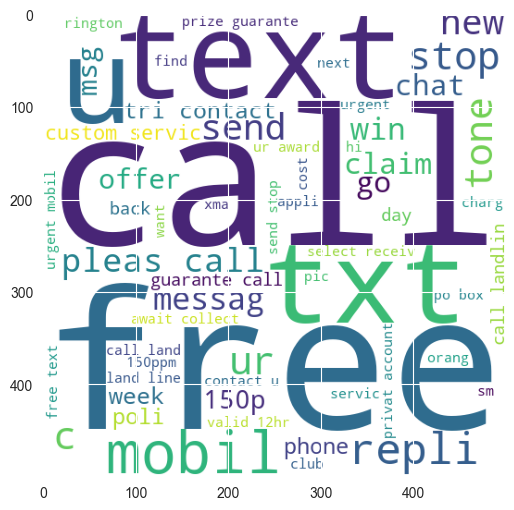

In [76]:
#utilizzo la libreria WordCLoud
from wordcloud import WordCloud

wc= WordCloud(width=500, height=500, min_font_size=10, background_color='white')

spam_words = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15, 6))
plt.imshow(spam_words)

Qui sopra ci sono le parole più diffuse nei testi si sms spam.
Ora vado a ricavare lo stesso grafico per gli sms ham.

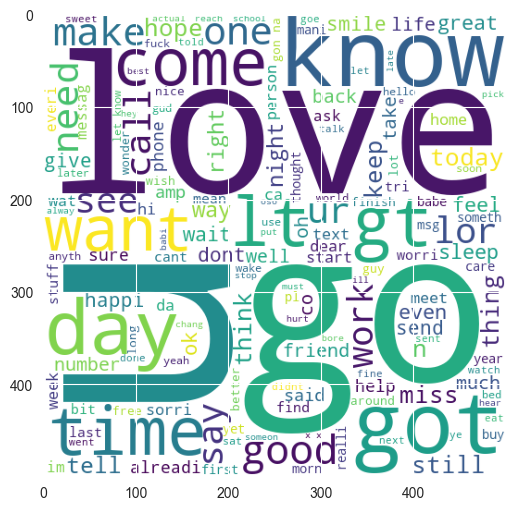

In [77]:
ham_words = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_words)

Quindi da questi due grafici va ad emergere quali sono le parole più diffuse negli sms ham/spam, quindi il classificatore andrà anche a basarsi sulla ricorrenza di tali parole per andare a classificare un sms.


## Data Preparation (Feature scaling)

Da come emerge, le scale fra numero di caratteri, numero di parole e numero di frasi sono diverse... quindi vado a normalizzare i vari valori utilizzando la tecnica più diffusa: min max normalization.

In [78]:
from sklearn.preprocessing import MinMaxScaler

#colonne che voglio normalizzare
features_to_normalize = ['num_characters', 'num_words', 'num_sentences']

#oggetto che permette la normalizzazione
scaler = MinMaxScaler() 

df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])



Stampo un campione per vedere se tutto ha avuto successo.

In [79]:
df.sample(10)

,target,text,num_characters,num_words,num_sentences,transformed_text
4726,1,Had your mobile 10 mths? Update to the latest ...,0.178934,0.148718,0.272727,mobil 10 mth updat latest phone free keep ur n...
4480,0,No..its ful of song lyrics..,0.032995,0.035897,0.000000,ful song lyric
4870,0,Well. You know what i mean. Texting,0.041878,0.041026,0.181818,well know mean text
1887,1,Urgent! Please call 09061743811 from landline....,0.191624,0.138462,0.181818,urgent pleas call 09061743811 landlin abta com...
5355,0,Living is very simple.. Loving is also simple....,0.181472,0.174359,0.181818,live simpl love also simpl laugh simpl win too...
958,0,My sort code is and acc no is . The bank is n...,0.142132,0.138462,0.181818,sort code acc bank natwest repli confirm sent ...
2231,0,"K, wen ur free come to my home and also tel vi...",0.162437,0.169231,0.090909,k wen ur free come home also tel vikki hav sen...
462,1,"UpgrdCentre Orange customer, you may now claim...",0.219543,0.184615,0.363636,upgrdcentr orang custom may claim free camera ...
2577,0,Hey whats up? U sleeping all morning?,0.044416,0.041026,0.090909,hey what u sleep morn
1636,0,"No shit, but I wasn't that surprised, so I wen...",0.206853,0.200000,0.000000,shit surpris went spent even french guy met to...


Come si può notare ora tutto è normalizzato

# Data Preparation (Feature Selection)

Si può notare che num_sentences assumeva già prima della feature scaling un valore quasi sempre uguale (1, 2, 3), quindi è una feature a bassa varianza... di conseguenza è una feature poco predittiva quindi procedo ad eliminarla.

In [80]:
df = df.drop('num_sentences', axis=1) #axis=1 vuol dire colonne, axis=0 righe

#stampo un sample per vedere se è tutto ok
df.sample(5)

,target,text,num_characters,num_words,transformed_text
4740,0,Many more happy returns of the day. I wish you...,0.076142,0.066667,mani happi return day wish happi birthday
1928,1,Call from 08702490080 - tells u 2 call 0906635...,0.181472,0.148718,call 08702490080 tell u 2 call 09066358152 cla...
1077,0,"Yep, by the pretty sculpture",0.032995,0.025641,yep pretti sculptur
3700,0,Shall i get my pouch?,0.024112,0.025641,shall get pouch
10,0,I'm gonna be home soon and i don't want to tal...,0.135787,0.138462,gon na home soon want talk stuff anymor tonigh...


## Modeling 